# customer_churn_project_english

It is necessary to predict whether the client will leave the bank in the near future or not. We have been provided with historical data on customer behavior and termination of agreements with the bank.

Let us construct a model with an extremely large *F1*-measure. To pass the project successfully, you need to bring the metric to 0.59. Check the *F1*-measure on the test set.

Additionally, we measure *AUC-ROC*, compare its value with *F1*-measure.

Data source: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Data preparation

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re as re

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_score, recall_score, precision_recall_curve, accuracy_score
from sklearn.utils import shuffle

from catboost import CatBoostClassifier
from catboost import Pool, cv

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import warnings
warnings.filterwarnings("ignore")


In [2]:
data = pd.read_csv("/workspaces/Data-Science/Customer_churn/dataset/Churn_Modelling.csv")
data.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


### Data exploration Churn_Modelling.csv

In [4]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


**Features:**

RowNumber - the index of the row in the data  
CustomerId - unique customer identifier  
Surname - surname  
CreditScore - credit rating  
Geography - country of residence  
Gender - gender  
Age - age  
Tenure - how many years a person has been a client of the bank  
Balance - account balance  
NumOfProducts - the number of bank products used by the client   
HasCrCard - availability of a credit card  
IsActiveMember - client activity  
EstimatedSalary - estimated salary  
Target column:  

Exited - the fact of the client's departure  


In [5]:
data.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in data.columns]#Let's convert the names of the columns to the snake register
data.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

In [6]:
data.columns = ['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited']#Let's convert the names of the columns to the snake register
data.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            10000 non-null  int64  
 8   balance           10000 non-null  float64
 9   num_of_products   10000 non-null  int64  
 10  has_cr_card       10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  float64
 13  exited            10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


### Consider the presence of rare and outliers by analyzing through the method .describe()

In [8]:
data.describe(include='all')

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
count,10000.00000,1.000000e+04,10000,10000.000000,10000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
unique,NaN,NaN,2932,NaN,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Smith,NaN,France,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,32,NaN,5014,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5000.50000,1.569094e+07,NaN,650.528800,NaN,NaN,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,NaN,96.653299,NaN,NaN,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,NaN,350.000000,NaN,NaN,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,NaN,584.000000,NaN,NaN,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,NaN,652.000000,NaN,NaN,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,NaN,718.000000,NaN,NaN,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000


* No anomalies

In [9]:
data.groupby('exited')['customer_id'].count()# consider the target feature. One in four leaves the bank

exited
0    7963
1    2037
Name: customer_id, dtype: int64

In [10]:
data[data['balance']==0].groupby('exited')['customer_id'].count()# Every sixth client with a zero balance leaves the bank

exited
0    3117
1     500
Name: customer_id, dtype: int64

### Check for duplicates

In [11]:
data.duplicated().sum()

0

### Remove non-informative columns not needed for the model row_number, customer_id, surname

In [12]:
data = data.drop(['row_number', 'customer_id', 'surname'], axis=1).copy()
data.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


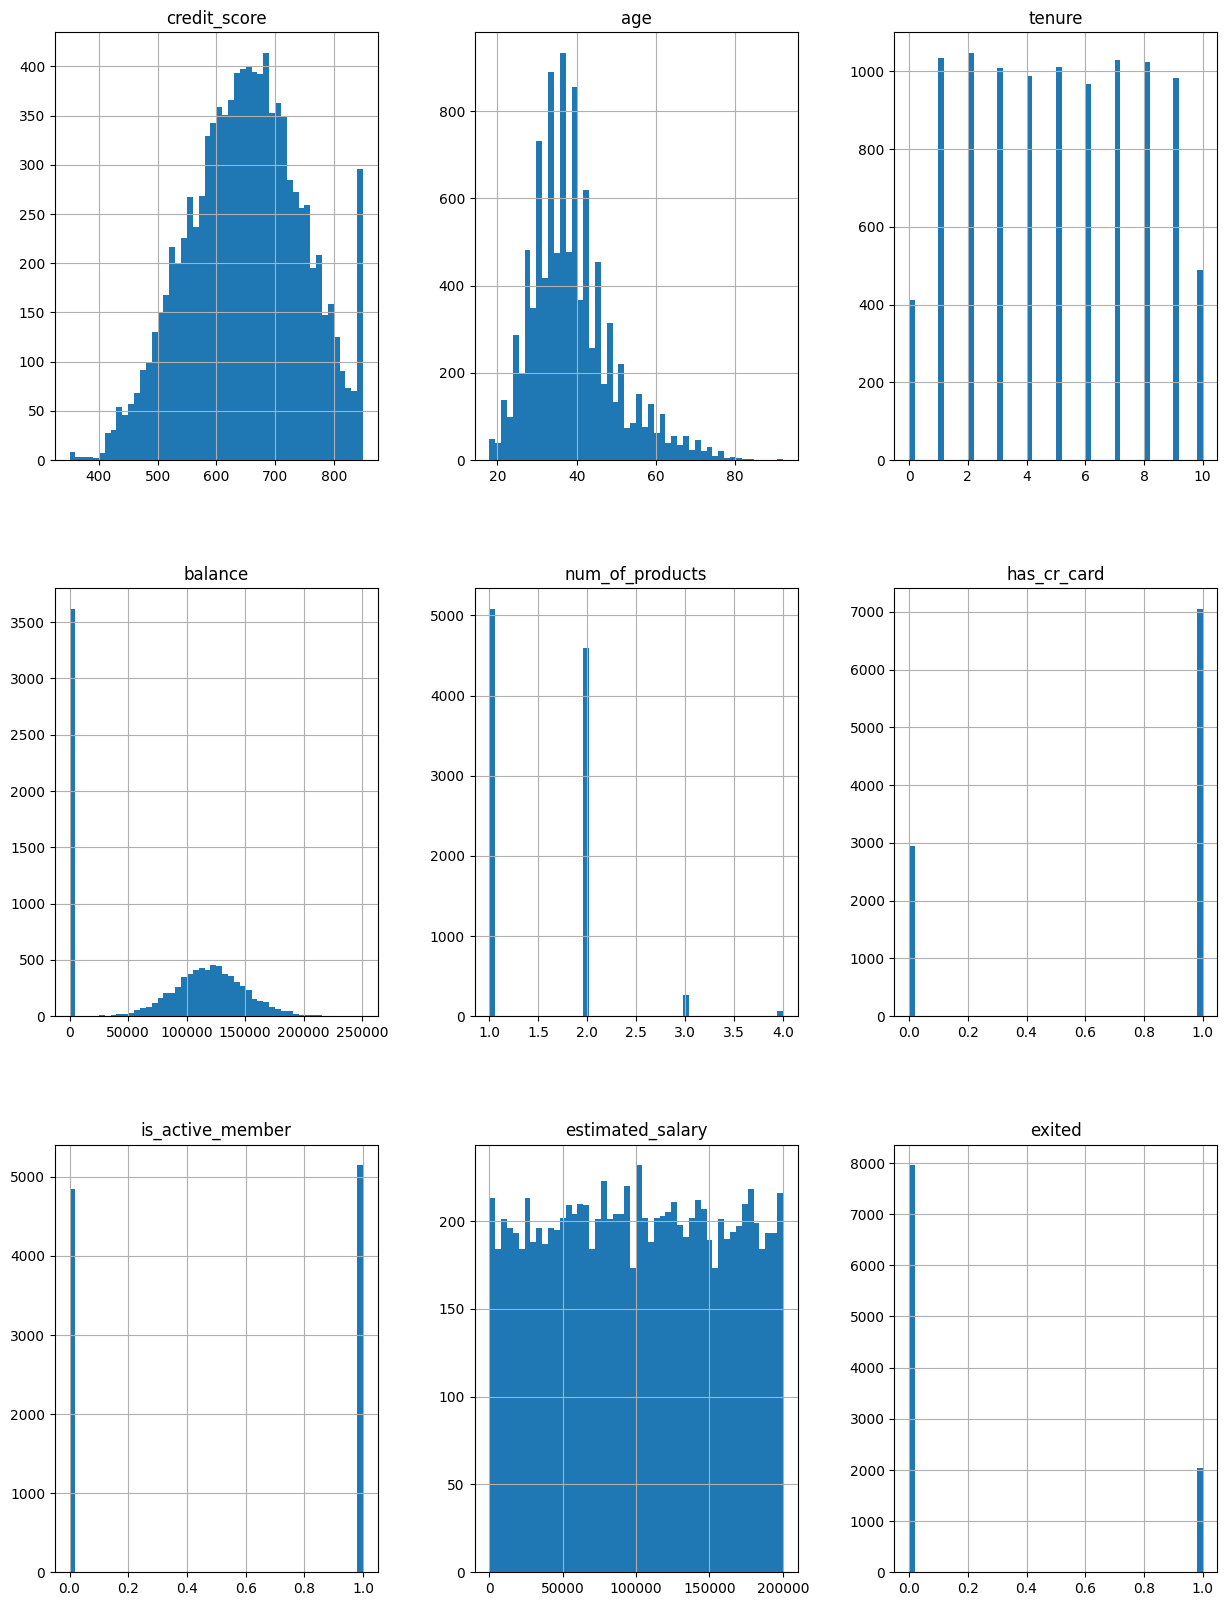

In [13]:
data.hist(bins=50, figsize=(15, 20))#built a common histogram for all numeric columns
plt.show()

### Findings

1. Out of 10,000 customers, 2,037 customers left the bank.
2. Column names are changed to snake and lowercase
3. Anomalies were not detected
4. There is an imbalance of classes. The number of customer exits is approximately four times less than the remaining
5. People with zero balances are more likely to leave the bank

## Problem research

Clients started leaving the bank. A little, but noticeable. Banking marketers figured it was cheaper to keep current customers than to attract new ones.
It is necessary to predict whether the client will leave the bank in the near future or not.
1. Let us construct a model with an extremely large value of the F1-measure. Let's check the F1-measure on the test sample.
2. Additionally, we measure the AUC-ROC, compare its value with the F1-measure.
3. We have an imbalance of classes, correctness (accuracy) does not suit us.
To solve this problem, I propose to use the algorithms of Logistic Regression, Random Forest and Decision Tree, Catboost

### One-hot Encoding

In [14]:
def unique_values(data):
    for column in data : 
        if data[column].dtypes == 'object':
            print(f'{column}:{data[column].unique()}:{len(data[column].unique())}')
unique_values(data)

geography:['France' 'Spain' 'Germany']:3
gender:['Female' 'Male']:2


Converting categorical features to numerical will help the direct coding technique, or One-Hot Encoding display.
The OHE technique converts categorical features into numerical features in two stages:
1. A new column is created for each characteristic value;
2. If the category is suitable for the object, 1 is assigned, if not, 0.
The new features are called dummy variables, or dummy features.
For direct encoding, the pandas library has the pd.get_dummies() function.
Let's convert the categorical features of the gender and geography columns with the One-hot Encoding method into numerical ones.

In [15]:
data.groupby('gender')['estimated_salary'].count()# consider the target feature

gender
Female    4543
Male      5457
Name: estimated_salary, dtype: int64

In [16]:
data.groupby('geography')['estimated_salary'].count()#consider the target feature

geography
France     5014
Germany    2509
Spain      2477
Name: estimated_salary, dtype: int64

In [17]:
data['gender'] = pd.get_dummies(data["gender"], drop_first=True)

In [18]:
pd.get_dummies(data["geography"], drop_first=True)

,Germany,Spain
0,0,0
1,0,1
2,0,0
3,0,0
4,0,1
...,...,...
9995,0,0
9996,0,0
9997,0,0
9998,1,0


In [19]:
data_ohe = pd.get_dummies(data["geography"], drop_first=True)

In [20]:
data = pd.concat([data, data_ohe], axis=1)#add new columns from geography

data.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,Germany,Spain
0,619,France,0,42,2,0.00,1,1,1,101348.88,1,0,0
1,608,Spain,0,41,1,83807.86,1,0,1,112542.58,0,0,1
2,502,France,0,42,8,159660.80,3,1,0,113931.57,1,0,0
3,699,France,0,39,1,0.00,2,0,0,93826.63,0,0,0
4,850,Spain,0,43,2,125510.82,1,1,1,79084.10,0,0,1


In [21]:
data = data.drop(['geography'], axis=1).copy()#remove the geography column
data.head()

,credit_score,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,Germany,Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,0,0
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0,1
2,502,0,42,8,159660.80,3,1,0,113931.57,1,0,0
3,699,0,39,1,0.00,2,0,0,93826.63,0,0,0
4,850,0,43,2,125510.82,1,1,1,79084.10,0,0,1


### Divide the data into samples

In [22]:
# separate 20% of the data for the test sample of the sample (for model validation)

In [23]:
target = data['exited']
features = data.drop(['exited'] , axis=1)
features_other, features_test, target_other, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345)

In [24]:
# separate 25% of the data (from other) to split into training and validation sets

In [25]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features_other, target_other, test_size=0.25, random_state=12345)

In [26]:
print('Training sample size', len(features_train))
print('Validation sample size', len(features_valid))
print('Test sample size', len(features_test))

Training sample size 6000
Validation sample size 2000
Test sample size 2000


### Feature scaling

If the data contains quantitative features with different ranges of values, then the algorithm may decide that features with large values and ranges are more important.   To avoid this
traps, signs are scaled - brought to the same scale.

In [27]:
numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_train.head()

,credit_score,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,Germany,Spain
492,-0.134048,0,-0.078068,-0.357205,0.076163,0.816929,0,1,0.331571,0,0
6655,-1.010798,1,0.494555,0.676673,0.136391,-0.896909,1,1,-0.727858,0,0
4287,0.639554,1,1.353490,-1.391083,0.358435,-0.896909,1,1,-0.477006,1,0
42,-0.990168,0,2.116987,-1.046457,0.651725,-0.896909,1,1,-0.100232,0,0
8178,0.567351,0,0.685430,0.676673,0.813110,0.816929,1,1,0.801922,0,0


In [28]:
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_valid.head()

,credit_score,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,Germany,Spain
2358,0.175393,1,0.399118,-1.391083,1.385698,-0.896909,0,1,-1.466761,0,0
8463,-1.299609,1,0.971741,-1.046457,-1.232442,-0.896909,1,0,0.254415,0,1
163,0.711757,0,-0.268942,-1.046457,-1.232442,0.816929,1,1,0.122863,0,1
3074,-0.391916,0,0.494555,0.332047,0.672529,-0.896909,1,0,0.585847,1,0
5989,0.165078,0,1.353490,1.710552,0.536522,-0.896909,0,0,1.462457,0,0


In [29]:
features_test[numeric] = scaler.transform(features_test[numeric])
features_test.head()

,credit_score,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,Germany,Spain
7867,-0.123733,0,0.685430,-0.701831,-1.232442,-0.896909,1,1,0.980212,0,1
1402,1.083087,1,-0.937002,1.021300,0.858518,-0.896909,1,0,-0.390486,0,0
8606,1.598822,1,0.303681,-0.012579,-1.232442,0.816929,1,1,-0.435169,0,1
8885,0.165078,1,0.589993,-0.357205,0.412100,0.816929,1,1,1.017079,0,1
6494,0.484834,1,-1.032439,0.676673,-1.232442,0.816929,1,1,-1.343558,0,0


### Examining models without imbalance

In [30]:
#for the convenience of output in the future - we will collect the indicators in lists
tabl_model = []
tabl_prec = []
tabl_not = []
tabl_roc_auc = []

#### Logistic Regression Model

In [31]:
model = LogisticRegression(solver = 'liblinear', penalty = 'l2', multi_class ='auto', fit_intercept=True, dual=False, C=10,
                           random_state=12345, max_iter=1000) 
model.fit(features_train, target_train) # train the model on the training data
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))# calculate the quality of the model on the validation set

probabilities_valid = model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))


F1: 0.30393996247654786
AUC_ROC = 0.770



In [32]:
tabl_prec.append(round(f1_score(target_valid, predicted_valid), 2))
tabl_roc_auc.append(round(auc_roc, 2))
tabl_model.append('LogisticRegression')
tabl_not.append('without_imbalance')


Small value F1. We will select parameters and disassemble with an imbalance later

#### Decision tree model

In [33]:
%%time
1 + 1
best_model = None
best_result = 0
for depth in range(1, 15):
	model = DecisionTreeClassifier(max_depth=depth) # train the model with a given tree depth
	model.fit(features_train, target_train) 
	predicted_valid = model.predict(features_valid)
	result = f1_score(target_valid, predicted_valid) 
	if result > best_result:
		best_model = model
		best_result = result

print("F1 best model:", best_result)
print("max_depth best model:", best_model)

probabilities_valid = best_model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

F1 best model: 0.5520504731861199
max_depth best model: DecisionTreeClassifier(max_depth=7)
AUC_ROC = 0.824

CPU times: user 271 ms, sys: 0 ns, total: 271 ms
Wall time: 271 ms


In [34]:
tabl_prec.append(round((best_result), 2))
tabl_roc_auc.append(round(auc_roc, 2))
tabl_model.append('DecisionTreeClassifier')
tabl_not.append('without_imbalance')



Much better, but consider other models

#### Random forest model

In [35]:
%%time
1 + 1

best_result = 0
for est in range(10, 101, 10):     
    for depth in range(1, 30):
        for samples_split in range(2, 51, 10):
            model = RandomForestClassifier(max_depth=depth, min_samples_split=samples_split, n_estimators=est, random_state=12345)
            model.fit(features_train, target_train) 
            predicted_valid = model.predict(features_valid) 
            result = f1_score(target_valid, predicted_valid)
            if result > best_result:
                best_model = model
                best_result = result

CPU times: user 7min 53s, sys: 498 ms, total: 7min 53s
Wall time: 7min 56s


In [36]:
best_model

RandomForestClassifier(max_depth=17, min_samples_split=12, n_estimators=30,
                       random_state=12345)

In [37]:
best_result

0.5819935691318328

In [38]:
print("F1:", best_result)
tabl_prec.append(round(best_result, 2))

probabilities_valid = best_model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

tabl_roc_auc.append(round(auc_roc, 2))
tabl_model.append('RandomForestClassifier')
tabl_not.append('without_imbalance')

F1: 0.5819935691318328
AUC_ROC = 0.843



This RandomForestClassifier model has the best result so far

#### CatBoostClassifier

In [39]:
model = CatBoostClassifier(verbose=100, random_state=12345)
model.fit(features_train, target_train)

predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

Learning rate set to 0.022141
0:	learn: 0.6754999	total: 49ms	remaining: 48.9s
100:	learn: 0.3343972	total: 276ms	remaining: 2.46s
200:	learn: 0.3110064	total: 499ms	remaining: 1.98s
300:	learn: 0.2963858	total: 729ms	remaining: 1.69s
400:	learn: 0.2844886	total: 975ms	remaining: 1.46s
500:	learn: 0.2741070	total: 1.19s	remaining: 1.19s
600:	learn: 0.2646223	total: 1.43s	remaining: 950ms
700:	learn: 0.2550124	total: 1.67s	remaining: 713ms
800:	learn: 0.2456157	total: 1.9s	remaining: 472ms
900:	learn: 0.2361567	total: 2.12s	remaining: 233ms
999:	learn: 0.2277176	total: 2.35s	remaining: 0us
F1: 0.596875
AUC_ROC = 0.864



In [40]:
tabl_prec.append(round(f1_score(target_valid, predicted_valid), 2))
tabl_roc_auc.append(round(auc_roc, 2))
tabl_model.append('CatBoostClassifier')
tabl_not.append('without_imbalance')

F1 measure is larger than in all other models

In [41]:
table_models = (pd.DataFrame({'Model':tabl_model, 'F1 score':tabl_prec, 'ROC-AUC':tabl_roc_auc, 'Notice': tabl_not}).sort_values(by='F1 score', ascending=False).
                  reset_index(drop=True))
table_models

,Model,F1 score,ROC-AUC,Notice
0,CatBoostClassifier,0.60,0.86,without_imbalance
1,RandomForestClassifier,0.58,0.84,without_imbalance
2,DecisionTreeClassifier,0.55,0.82,without_imbalance
3,LogisticRegression,0.30,0.77,without_imbalance


### Findings

1. Transformed categorical features into numerical ones using direct coding technique, or One-Hot Encoding mapping.
2. Divided the data into samples in the ratio 60-20-20
3. Brought signs to a single scale to avoid the trap
4. We studied the models without taking into account the imbalance. The models CatBoostClassifier, RandomForestClassifier performed best
5. Compared parameters f1 and ROC-AUC models

## Struggling with imbalance

In [42]:
data.groupby('exited')['exited'].count()# Let's look at the target. One in four leaves the bank. There is a class imbalance

exited
0    7963
1    2037
Name: exited, dtype: int64

### class_weight='balanced'

#### Logistic Regression Model

In [43]:
model = LogisticRegression(solver = 'liblinear', penalty = 'l2', multi_class ='auto', fit_intercept=True, dual=False, C=10,
                           random_state=12345, max_iter=1000, class_weight='balanced') 
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

F1: 0.4821428571428571
AUC_ROC = 0.772



In [44]:
tabl_prec.append(round(f1_score(target_valid, predicted_valid), 2))
tabl_roc_auc.append(round(auc_roc, 2))
tabl_model.append('LogisticRegression')
tabl_not.append('class_weight')

#### Decision tree model

In [45]:
%%time
1 + 1
best_model = None
best_result = 0
for depth in range(1, 15):
	model = DecisionTreeClassifier(max_depth=depth, random_state=12345, class_weight='balanced') 
	model.fit(features_train, target_train)
	predicted_valid = model.predict(features_valid)
	result = f1_score(target_valid, predicted_valid) 
	if result > best_result:
		best_model = model
		best_result = result

print("F1 best model:", best_result)
print("max_depth best model:", best_model)

probabilities_valid = best_model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

F1 best model: 0.5572441742654509
max_depth best model: DecisionTreeClassifier(class_weight='balanced', max_depth=6, random_state=12345)
AUC_ROC = 0.807

CPU times: user 339 ms, sys: 0 ns, total: 339 ms
Wall time: 339 ms


In [46]:
tabl_prec.append(round((best_result), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('DecisionTreeClassifier')
tabl_not.append('class_weight')

#### Random forest model

In [47]:
%%time
1 + 1

model = RandomForestClassifier(class_weight='balanced', max_depth=17, min_samples_leaf=2, min_samples_split=12,
                       n_estimators=30,random_state=12345)

model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = best_model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

F1: 0.583547557840617
AUC_ROC = 0.807

CPU times: user 190 ms, sys: 7.91 ms, total: 198 ms
Wall time: 200 ms


In [48]:
tabl_prec.append(round(f1_score(target_valid, predicted_valid), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('RandomForestClassifier')
tabl_not.append('class_weight')

By adding the class_weight='balanced' parameter, a rare class will have more weight.

In [49]:
table_models = (pd.DataFrame({'Model':tabl_model, 'F1 score':tabl_prec, 'ROC-AUC':tabl_roc_auc, 'Notice': tabl_not}).sort_values(by='F1 score', ascending=False).
                  reset_index(drop=True))
table_models

,Model,F1 score,ROC-AUC,Notice
0,CatBoostClassifier,0.60,0.86,without_imbalance
1,RandomForestClassifier,0.58,0.84,without_imbalance
2,RandomForestClassifier,0.58,0.81,class_weight
3,DecisionTreeClassifier,0.56,0.81,class_weight
4,DecisionTreeClassifier,0.55,0.82,without_imbalance
5,LogisticRegression,0.48,0.77,class_weight
6,LogisticRegression,0.30,0.77,without_imbalance


#### Comparison:

Two models (DecisionTreeClassifier, LogisticRegression) increased the F1 measure and the ROC-AUC indicator using the class_weight='balanced' parameter

### upsampling.

In [50]:
oversample = SMOTE(random_state=12345)

In [51]:
features_upsampled, target_upsampled = oversample.fit_resample(features_train, target_train)

In [52]:
print('Upsampled validation sample size', len(features_upsampled))

Upsampled validation sample size 9562


#### Logistic Regression Model

In [53]:
model = LogisticRegression(solver='liblinear', random_state=12345)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

F1: 0.479108635097493
AUC_ROC = 0.765



In [54]:
tabl_prec.append(round(f1_score(target_valid, predicted_valid), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('LogisticRegression')
tabl_not.append('upsampling')

#### Decision tree model

In [55]:
%%time
1 + 1
best_model = None
best_result = 0
for depth in range(1, 15):
	model = DecisionTreeClassifier(max_depth=depth)
	model.fit(features_upsampled, target_upsampled) 
	predicted_valid = model.predict(features_valid) 
	result = f1_score(target_valid, predicted_valid) 
	if result > best_result:
		best_model = model
		best_result = result

print("F1 best model:", best_result)
print("max_depth лучшей модели:", best_model)

probabilities_valid = best_model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))


F1 best model: 0.5567226890756302
max_depth лучшей модели: DecisionTreeClassifier(max_depth=5)
AUC_ROC = 0.821

CPU times: user 461 ms, sys: 7.98 ms, total: 469 ms
Wall time: 468 ms


In [56]:
tabl_prec.append(round((best_result), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('DecisionTreeClassifier')
tabl_not.append('upsampling')

#### Random forest model.

In [57]:
%%time
1 + 1
model = RandomForestClassifier(max_depth=17, min_samples_leaf=2, min_samples_split=12,
                       n_estimators=30, random_state=12345)

model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

F1: 0.5842696629213483
AUC_ROC = 0.843

CPU times: user 360 ms, sys: 0 ns, total: 360 ms
Wall time: 359 ms


In [58]:
tabl_prec.append(round(f1_score(target_valid, predicted_valid), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('RandomForestClassifier')
tabl_not.append('upsampling')

#### CatBoostClassifier

In [59]:
model = CatBoostClassifier(verbose=100, random_state=12345)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

auc_roc = roc_auc_score(target_valid, predicted_valid)
print('ROC-AUC:', auc_roc)

Learning rate set to 0.027016
0:	learn: 0.6778800	total: 4.86ms	remaining: 4.85s
100:	learn: 0.3859493	total: 325ms	remaining: 2.9s
200:	learn: 0.3243032	total: 660ms	remaining: 2.62s
300:	learn: 0.2843332	total: 968ms	remaining: 2.25s
400:	learn: 0.2568472	total: 1.31s	remaining: 1.96s
500:	learn: 0.2364721	total: 1.63s	remaining: 1.62s
600:	learn: 0.2198285	total: 1.94s	remaining: 1.29s
700:	learn: 0.2067733	total: 2.27s	remaining: 966ms
800:	learn: 0.1963333	total: 2.61s	remaining: 649ms
900:	learn: 0.1869532	total: 2.96s	remaining: 325ms
999:	learn: 0.1778376	total: 3.28s	remaining: 0us
F1: 0.6022727272727274
ROC-AUC: 0.7397137902368233


In [60]:
tabl_prec.append(round(f1_score(target_valid, predicted_valid), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('CatBoostClassifier')
tabl_not.append('upsampling')

In [61]:
table_models = (pd.DataFrame({'Model':tabl_model, 'F1 score':tabl_prec, 'ROC-AUC':tabl_roc_auc, 'Notice': tabl_not}).sort_values(by='F1 score', ascending=False).
                  reset_index(drop=True))
table_models

,Model,F1 score,ROC-AUC,Notice
0,CatBoostClassifier,0.60,0.86,without_imbalance
1,CatBoostClassifier,0.60,0.74,upsampling
2,RandomForestClassifier,0.58,0.84,without_imbalance
3,RandomForestClassifier,0.58,0.81,class_weight
4,RandomForestClassifier,0.58,0.84,upsampling
5,DecisionTreeClassifier,0.56,0.81,class_weight
6,DecisionTreeClassifier,0.56,0.82,upsampling
7,DecisionTreeClassifier,0.55,0.82,without_imbalance
8,LogisticRegression,0.48,0.77,class_weight
9,LogisticRegression,0.48,0.77,upsampling


#### Comparison:

By increasing the sample, we improved the LogisticRegression, DecisionTreeClassifier model. For CatBoostClassifier and RandomForestClassifier models, values are worse than before debalancing

### downsampling. Sample reduction

In [62]:
downsample = RandomUnderSampler(random_state=12345)

In [63]:
features_downsampled, target_downsampled = downsample.fit_resample(features_train, target_train)

In [64]:
print('Size of the downsampled validation sample', len(features_downsampled))

Size of the downsampled validation sample 2438


#### Logistic Regression Model

In [65]:
model = LogisticRegression(solver='liblinear', random_state=12345)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

F1: 0.4763603925066905
AUC_ROC = 0.774



In [66]:
tabl_prec.append(round(f1_score(target_valid, predicted_valid), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('LogisticRegression')
tabl_not.append('downsampled')

#### Decision tree model

In [67]:
%%time
1 + 1
best_model = None
best_result = 0
for depth in range(1, 15):
	model = DecisionTreeClassifier(max_depth=depth) 
	model.fit(features_downsampled, target_downsampled) 
	predicted_valid = model.predict(features_valid) 
	result = f1_score(target_valid, predicted_valid) 
	if result > best_result:
		best_model = model
		best_result = result

print("F1 best model:", best_result)
print("max_depth best model:", best_model)

probabilities_valid = best_model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))


F1 best model: 0.549718574108818
max_depth best model: DecisionTreeClassifier(max_depth=6)
AUC_ROC = 0.813

CPU times: user 147 ms, sys: 0 ns, total: 147 ms
Wall time: 147 ms


In [68]:
tabl_prec.append(round((best_result), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('DecisionTreeClassifier')
tabl_not.append('downsampled')

#### Random forest model

In [69]:
%%time
1 + 1
model = RandomForestClassifier(max_depth=17, min_samples_leaf=2, min_samples_split=12,
                       n_estimators=30, random_state=12345)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

F1: 0.5436893203883495
AUC_ROC = 0.838

CPU times: user 160 ms, sys: 0 ns, total: 160 ms
Wall time: 159 ms


In [70]:
tabl_prec.append(round(f1_score(target_valid, predicted_valid), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('RandomForestClassifier')
tabl_not.append('downsampled')

#### CatBoostClassifier

In [71]:
model = CatBoostClassifier(verbose=100, random_state=12345)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

Learning rate set to 0.015073
0:	learn: 0.6858003	total: 1.66ms	remaining: 1.66s
100:	learn: 0.4611947	total: 164ms	remaining: 1.46s
200:	learn: 0.4195959	total: 319ms	remaining: 1.27s
300:	learn: 0.3960656	total: 460ms	remaining: 1.07s
400:	learn: 0.3775319	total: 602ms	remaining: 899ms
500:	learn: 0.3599686	total: 739ms	remaining: 736ms
600:	learn: 0.3440070	total: 876ms	remaining: 582ms
700:	learn: 0.3277725	total: 1.02s	remaining: 434ms
800:	learn: 0.3132693	total: 1.16s	remaining: 287ms
900:	learn: 0.2992471	total: 1.3s	remaining: 143ms
999:	learn: 0.2868099	total: 1.44s	remaining: 0us
F1: 0.5731108930323846
AUC_ROC = 0.853



In [72]:
tabl_prec.append(round(f1_score(target_valid, predicted_valid), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('CatBoostClassifier')
tabl_not.append('downsampled')

In [73]:
table_models = (pd.DataFrame({'Model':tabl_model, 'F1 score':tabl_prec, 'ROC-AUC':tabl_roc_auc, 'Notice': tabl_not}).sort_values(by='F1 score', ascending=False).
                  reset_index(drop=True))
table_models

,Model,F1 score,ROC-AUC,Notice
0,CatBoostClassifier,0.60,0.86,without_imbalance
1,CatBoostClassifier,0.60,0.74,upsampling
2,RandomForestClassifier,0.58,0.84,without_imbalance
3,RandomForestClassifier,0.58,0.81,class_weight
4,RandomForestClassifier,0.58,0.84,upsampling
5,CatBoostClassifier,0.57,0.85,downsampled
6,DecisionTreeClassifier,0.56,0.81,class_weight
7,DecisionTreeClassifier,0.56,0.82,upsampling
8,DecisionTreeClassifier,0.55,0.82,without_imbalance
9,DecisionTreeClassifier,0.55,0.81,downsampled


#### Comparison:

Significantly worse performance for all models except LogisticRegression.

### Changing the qualification threshold

The boundary where the negative class ends and the positive class begins is called the threshold. By default it is 0.5, but you can change it.

#### Logistic Regression Model

In [74]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)[:, 1]

best_f1 = 0
for threshold in np.arange(0, 0.95, 0.05):
    predicted_valid = probabilities_valid > threshold 
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    F1 = f1_score(target_valid, predicted_valid)
    print("threshold = {:.2f} | precision = {:.3f}, recall = {:.3f}, F1 = {:.3f}".format(threshold, precision, recall, F1))
    if F1>best_f1:
        best_f1 = F1

auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("ROC-AUC = {:.3f}".format(auc_roc))     
print("F1-мера = {:.3f}".format(best_f1))

threshold = 0.00 | precision = 0.196, recall = 1.000, F1 = 0.327
threshold = 0.05 | precision = 0.218, recall = 0.987, F1 = 0.357
threshold = 0.10 | precision = 0.265, recall = 0.926, F1 = 0.412
threshold = 0.15 | precision = 0.314, recall = 0.813, F1 = 0.453
threshold = 0.20 | precision = 0.356, recall = 0.696, F1 = 0.471
threshold = 0.25 | precision = 0.397, recall = 0.575, F1 = 0.470
threshold = 0.30 | precision = 0.458, recall = 0.514, F1 = 0.484
threshold = 0.35 | precision = 0.518, recall = 0.442, F1 = 0.477
threshold = 0.40 | precision = 0.537, recall = 0.368, F1 = 0.437
threshold = 0.45 | precision = 0.512, recall = 0.274, F1 = 0.357
threshold = 0.50 | precision = 0.570, recall = 0.207, F1 = 0.304
threshold = 0.55 | precision = 0.616, recall = 0.156, F1 = 0.249
threshold = 0.60 | precision = 0.618, recall = 0.107, F1 = 0.183
threshold = 0.65 | precision = 0.684, recall = 0.066, F1 = 0.121
threshold = 0.70 | precision = 0.609, recall = 0.036, F1 = 0.068
threshold = 0.75 | precis

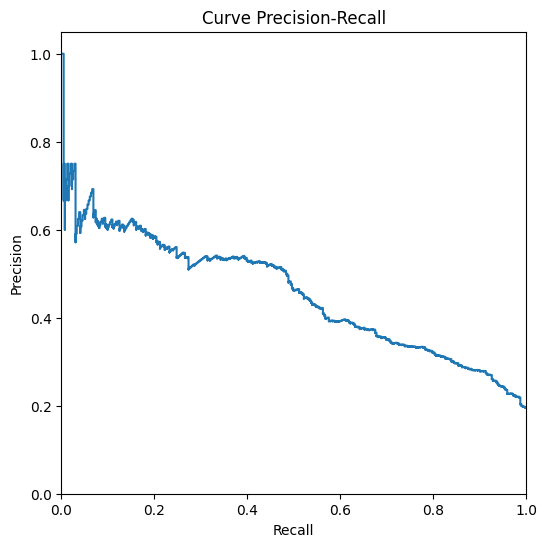

In [75]:
probabilities_valid = model.predict_proba(features_valid)
precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Curve Precision-Recall')

plt.show()

For a threshold of 0.30, the highest F1 and ROC-AUC

In [76]:
tabl_prec.append(round(best_f1, 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('LogisticRegression')
tabl_not.append('threshold=0.3')

In [77]:
table_models = (pd.DataFrame({'Model':tabl_model, 'F1 score':tabl_prec, 'ROC-AUC':tabl_roc_auc, 'Notice': tabl_not}).sort_values(by='F1 score', ascending=False).
                  reset_index(drop=True))
table_models

,Model,F1 score,ROC-AUC,Notice
0,CatBoostClassifier,0.60,0.86,without_imbalance
1,CatBoostClassifier,0.60,0.74,upsampling
2,RandomForestClassifier,0.58,0.84,without_imbalance
3,RandomForestClassifier,0.58,0.81,class_weight
4,RandomForestClassifier,0.58,0.84,upsampling
5,CatBoostClassifier,0.57,0.85,downsampled
6,DecisionTreeClassifier,0.56,0.81,class_weight
7,DecisionTreeClassifier,0.56,0.82,upsampling
8,DecisionTreeClassifier,0.55,0.82,without_imbalance
9,DecisionTreeClassifier,0.55,0.81,downsampled


#### Decision tree model

In [78]:
%%time
1 + 1
model = DecisionTreeClassifier(max_depth=5) 
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)[:, 1]

best_f1 = 0
for threshold in np.arange(0, 0.95, 0.05):
    predicted_valid = probabilities_valid > threshold 
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    F1 = f1_score(target_valid, predicted_valid)
    print("threshold = {:.2f} | precision = {:.3f}, recall = {:.3f}, F1 = {:.3f}".format(threshold, precision, recall, F1))
    if F1>best_f1:
        best_f1 = F1

auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("ROC-AUC = {:.3f}".format(auc_roc))     
print("F1-мера = {:.3f}".format(best_f1))

threshold = 0.00 | precision = 0.194, recall = 0.992, F1 = 0.325
threshold = 0.05 | precision = 0.248, recall = 0.957, F1 = 0.393
threshold = 0.10 | precision = 0.389, recall = 0.803, F1 = 0.524
threshold = 0.15 | precision = 0.389, recall = 0.803, F1 = 0.524
threshold = 0.20 | precision = 0.431, recall = 0.724, F1 = 0.541
threshold = 0.25 | precision = 0.567, recall = 0.542, F1 = 0.554
threshold = 0.30 | precision = 0.567, recall = 0.542, F1 = 0.554
threshold = 0.35 | precision = 0.567, recall = 0.542, F1 = 0.554
threshold = 0.40 | precision = 0.678, recall = 0.473, F1 = 0.557
threshold = 0.45 | precision = 0.678, recall = 0.473, F1 = 0.557
threshold = 0.50 | precision = 0.690, recall = 0.450, F1 = 0.545
threshold = 0.55 | precision = 0.737, recall = 0.394, F1 = 0.513
threshold = 0.60 | precision = 0.844, recall = 0.263, F1 = 0.402
threshold = 0.65 | precision = 0.844, recall = 0.263, F1 = 0.402
threshold = 0.70 | precision = 0.851, recall = 0.263, F1 = 0.402
threshold = 0.75 | precis

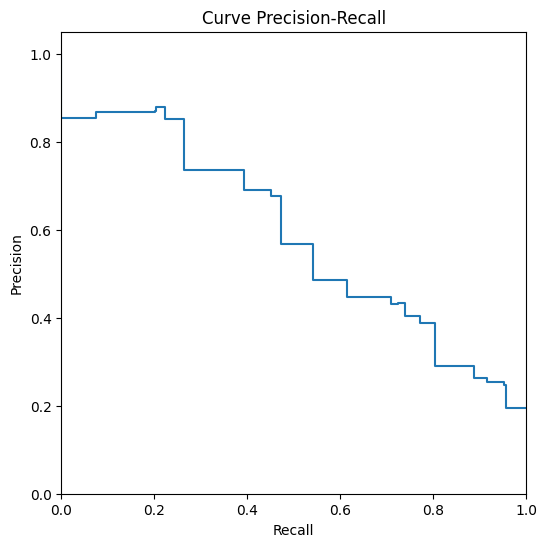

In [79]:
probabilities_valid = model.predict_proba(features_valid)
precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Curve Precision-Recall')
plt.show()

For a threshold of 0.4, the highest F1

In [80]:
tabl_prec.append(round(best_f1, 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('DecisionTreeClassifier')
tabl_not.append('threshold=0.4')

In [81]:
table_models = (pd.DataFrame({'Model':tabl_model, 'F1 score':tabl_prec, 'ROC-AUC':tabl_roc_auc, 'Notice': tabl_not}).sort_values(by='F1 score', ascending=False).
                  reset_index(drop=True))
table_models

,Model,F1 score,ROC-AUC,Notice
0,CatBoostClassifier,0.60,0.86,without_imbalance
1,CatBoostClassifier,0.60,0.74,upsampling
2,RandomForestClassifier,0.58,0.84,upsampling
3,RandomForestClassifier,0.58,0.84,without_imbalance
4,RandomForestClassifier,0.58,0.81,class_weight
5,CatBoostClassifier,0.57,0.85,downsampled
6,DecisionTreeClassifier,0.56,0.82,upsampling
7,DecisionTreeClassifier,0.56,0.82,threshold=0.4
8,DecisionTreeClassifier,0.56,0.81,class_weight
9,DecisionTreeClassifier,0.55,0.82,without_imbalance


#### Random forest model

In [82]:
%%time
1 + 1
model = RandomForestClassifier(max_depth=17, min_samples_leaf=2, min_samples_split=12,
                       n_estimators=30, random_state=12345)

model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)[:, 1]

best_f1 = 0 

for threshold in np.arange(0, 0.95, 0.05):
    predicted_valid = probabilities_valid > threshold 
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    F1 = f1_score(target_valid, predicted_valid)
    print("threshold = {:.2f} | precision = {:.3f}, recall = {:.3f}, F1 = {:.3f}".format(threshold, precision, recall, F1))
    if F1>best_f1:
        best_f1 = F1

auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("ROC-AUC = {:.3f}".format(auc_roc))     
print("F1-мера = {:.3f}".format(best_f1)) 

threshold = 0.00 | precision = 0.198, recall = 0.997, F1 = 0.331
threshold = 0.05 | precision = 0.251, recall = 0.959, F1 = 0.398
threshold = 0.10 | precision = 0.313, recall = 0.908, F1 = 0.465
threshold = 0.15 | precision = 0.360, recall = 0.829, F1 = 0.502
threshold = 0.20 | precision = 0.422, recall = 0.770, F1 = 0.545
threshold = 0.25 | precision = 0.479, recall = 0.698, F1 = 0.568
threshold = 0.30 | precision = 0.543, recall = 0.642, F1 = 0.589
threshold = 0.35 | precision = 0.628, recall = 0.596, F1 = 0.612
threshold = 0.40 | precision = 0.683, recall = 0.540, F1 = 0.603
threshold = 0.45 | precision = 0.706, recall = 0.478, F1 = 0.570
threshold = 0.50 | precision = 0.760, recall = 0.430, F1 = 0.549
threshold = 0.55 | precision = 0.784, recall = 0.389, F1 = 0.520
threshold = 0.60 | precision = 0.822, recall = 0.355, F1 = 0.496
threshold = 0.65 | precision = 0.866, recall = 0.315, F1 = 0.462
threshold = 0.70 | precision = 0.886, recall = 0.279, F1 = 0.424
threshold = 0.75 | precis

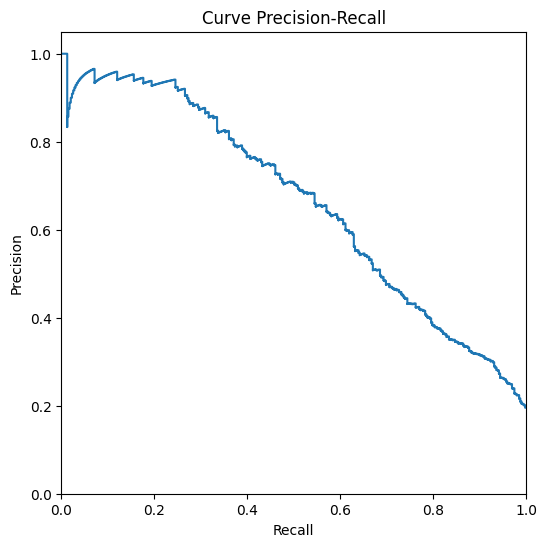

In [83]:
probabilities_valid = model.predict_proba(features_valid)
precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Curve Precision-Recall')
plt.show()

For a threshold of 0.35, the highest F1

In [84]:
tabl_prec.append(round(best_f1, 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('RandomForestClassifier')
tabl_not.append('threshold=0.35')

In [85]:
%%time
1 + 1
model = CatBoostClassifier(verbose=100, random_state=12345)

model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)[:, 1]

best_f1 = 0 

for threshold in np.arange(0, 0.95, 0.05):
    predicted_valid = probabilities_valid > threshold 
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    F1 = f1_score(target_valid, predicted_valid)
    print("threshold = {:.2f} | precision = {:.3f}, recall = {:.3f}, F1 = {:.3f}".format(threshold, precision, recall, F1))
    if F1>best_f1:
        best_f1 = F1

auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("ROC-AUC = {:.3f}".format(auc_roc))     
print("F1-мера = {:.3f}".format(best_f1)) 

Learning rate set to 0.022141
0:	learn: 0.6754999	total: 2.72ms	remaining: 2.72s
100:	learn: 0.3343972	total: 226ms	remaining: 2.01s
200:	learn: 0.3110064	total: 451ms	remaining: 1.79s
300:	learn: 0.2963858	total: 674ms	remaining: 1.56s
400:	learn: 0.2844886	total: 891ms	remaining: 1.33s
500:	learn: 0.2741070	total: 1.11s	remaining: 1.1s
600:	learn: 0.2646223	total: 1.33s	remaining: 885ms
700:	learn: 0.2550124	total: 1.57s	remaining: 669ms
800:	learn: 0.2456157	total: 1.86s	remaining: 464ms
900:	learn: 0.2361567	total: 2.08s	remaining: 229ms
999:	learn: 0.2277176	total: 2.3s	remaining: 0us
threshold = 0.00 | precision = 0.196, recall = 1.000, F1 = 0.327
threshold = 0.05 | precision = 0.281, recall = 0.944, F1 = 0.433
threshold = 0.10 | precision = 0.364, recall = 0.877, F1 = 0.515
threshold = 0.15 | precision = 0.433, recall = 0.803, F1 = 0.562
threshold = 0.20 | precision = 0.501, recall = 0.752, F1 = 0.601
threshold = 0.25 | precision = 0.542, recall = 0.696, F1 = 0.609
threshold = 0

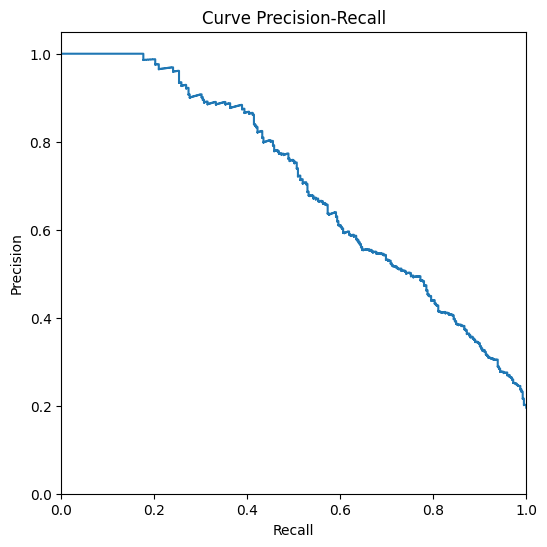

In [86]:
probabilities_valid = model.predict_proba(features_valid)
precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Curve Precision-Recall')
plt.show()

The highest score with a threshold of 0.25

In [87]:
tabl_prec.append(round(best_f1, 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('CatBoostClassifier')
tabl_not.append('threshold=0.25')

In [88]:
table_models = (pd.DataFrame({'Model':tabl_model, 'F1 score':tabl_prec, 'ROC-AUC':tabl_roc_auc, 'Notice': tabl_not}).sort_values(by='F1 score', ascending=False).
                  reset_index(drop=True))
table_models

,Model,F1 score,ROC-AUC,Notice
0,CatBoostClassifier,0.61,0.86,threshold=0.25
1,RandomForestClassifier,0.61,0.84,threshold=0.35
2,CatBoostClassifier,0.60,0.86,without_imbalance
3,CatBoostClassifier,0.60,0.74,upsampling
4,RandomForestClassifier,0.58,0.81,class_weight
5,RandomForestClassifier,0.58,0.84,upsampling
6,RandomForestClassifier,0.58,0.84,without_imbalance
7,CatBoostClassifier,0.57,0.85,downsampled
8,DecisionTreeClassifier,0.56,0.81,class_weight
9,DecisionTreeClassifier,0.56,0.82,upsampling


#### Comparison:

Changing the qualification threshold was able to significantly improve the models.

## Conclusion

<div class="alert alert-info"> <b>
We have determined the two most successful models - CatBoostClassifier with the best F1-measure and ROC-AUC measure obtained with threshold=0.25 and RandomForestClassifier with threshold 0.3. Let's try to find the optimal hyperparameters for it.

     1. In addition, we found that if there is an imbalance for our task, the best option is to change the threshold for RandomForestClassifier and a little for CatBoostClassifier.
     2. The increase in the sample proved to be better than its decrease. But not suitable for CatBoostClassifier and RandomForestClassifier
</div>

## Hyperparameter optimization for random forest model

### Stage 1. RandomizedSearchCV

You can start with the RandomizedSearchCV algorithm, which allows you to pretty roughly explore wide ranges of values. We will check on the sample (other), with the class_weight = {1:3.5} parameter using cross-validation. We get the base model, we will check it by the F1-measure.

In [89]:
%%time
1 + 1
n_estimators = [int(x) for x in np.linspace(start = 2, stop = 100, num = 25)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 20, num = 20)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 25)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 25)]
bootstrap = [True, False]
class_weight = [{1:3.5}, {1:3.6}, {1:3.4},]
#As we work, we generate a param_dist entity containing, for each hyperparameter, the range of values to be tested
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
             'class_weight': class_weight}
model = RandomizedSearchCV(RandomForestClassifier(), 
                        param_dist, 
                        n_iter = 100, 
                        cv = 5, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=12345,
                        scoring = 'f1')
model.fit(features_other, target_other)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: user 1.84 s, sys: 156 ms, total: 1.99 s
Wall time: 1min 22s


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': [{1: 3.5}, {1: 3.6},
                                                         {1: 3.4}],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [2, 4, 6, 8, 10, 12,
                                                             14, 16, 18, 20, 22,
                                                             24, 26, 28, 30, 32,
                                                             34, 36, 38, 40, 42,
                                                             44, 46, 48, 50],
                                        'min_samples_split': [2, 4, 6, 8, 10,
                                                              12, 14, 16, 18,
                                                              20, 22, 24, 26,
                                                              28, 30, 32, 34,
                                                              36, 38, 40, 42,
                                                              44, 46, 48, 50],
                                        'n_estimators': [2, 6, 10, 14, 18, 22,
                                                         26, 30, 34, 38, 42, 46,
                                                         51, 55, 59, 63, 67, 71,
                                                         75, 79, 83, 87, 91, 95,
                                                         100]},
                   random_state=12345, scoring='f1', verbose=1)

* With parameter values n_iter = 100 and cv = 5, we created 500 RF models by randomly selecting combinations of the above hyperparameters
* In order to find out in what range of values it is worth continuing the search, we can easily get a dataframe containing the results of the RandomizedSearchCV algorithm.

In [90]:
rs_df = pd.DataFrame(model.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_class_weight,param_bootstrap,split3_test_score,split4_test_score,mean_test_score,rank_test_score
0,51,6,10,sqrt,10,{1: 3.5},False,0.628571,0.652542,0.620221,1
1,67,36,2,sqrt,14,{1: 3.4},True,0.615385,0.639517,0.614641,2
2,55,8,6,log2,11,{1: 3.6},False,0.621100,0.638607,0.614495,3
3,83,36,4,sqrt,15,{1: 3.4},False,0.620384,0.639205,0.612215,4
4,91,34,4,log2,8,{1: 3.4},True,0.616519,0.630528,0.611386,5
...,...,...,...,...,...,...,...,...,...,...,...
95,2,46,32,log2,8,{1: 3.6},True,0.540476,0.475854,0.526393,96
96,59,40,28,sqrt,1,{1: 3.4},False,0.531335,0.559375,0.525605,97
97,91,50,34,sqrt,1,{1: 3.6},True,0.489493,0.562176,0.524522,98
98,42,50,16,log2,1,{1: 3.5},False,0.564341,0.539291,0.522684,99


Now let's create bar graphs, on which, along the x-axis, the values of hyperparameters are located, and along the y-axis, the average values shown by the models. This will allow you to understand which hyperparameter values, on average, perform best.

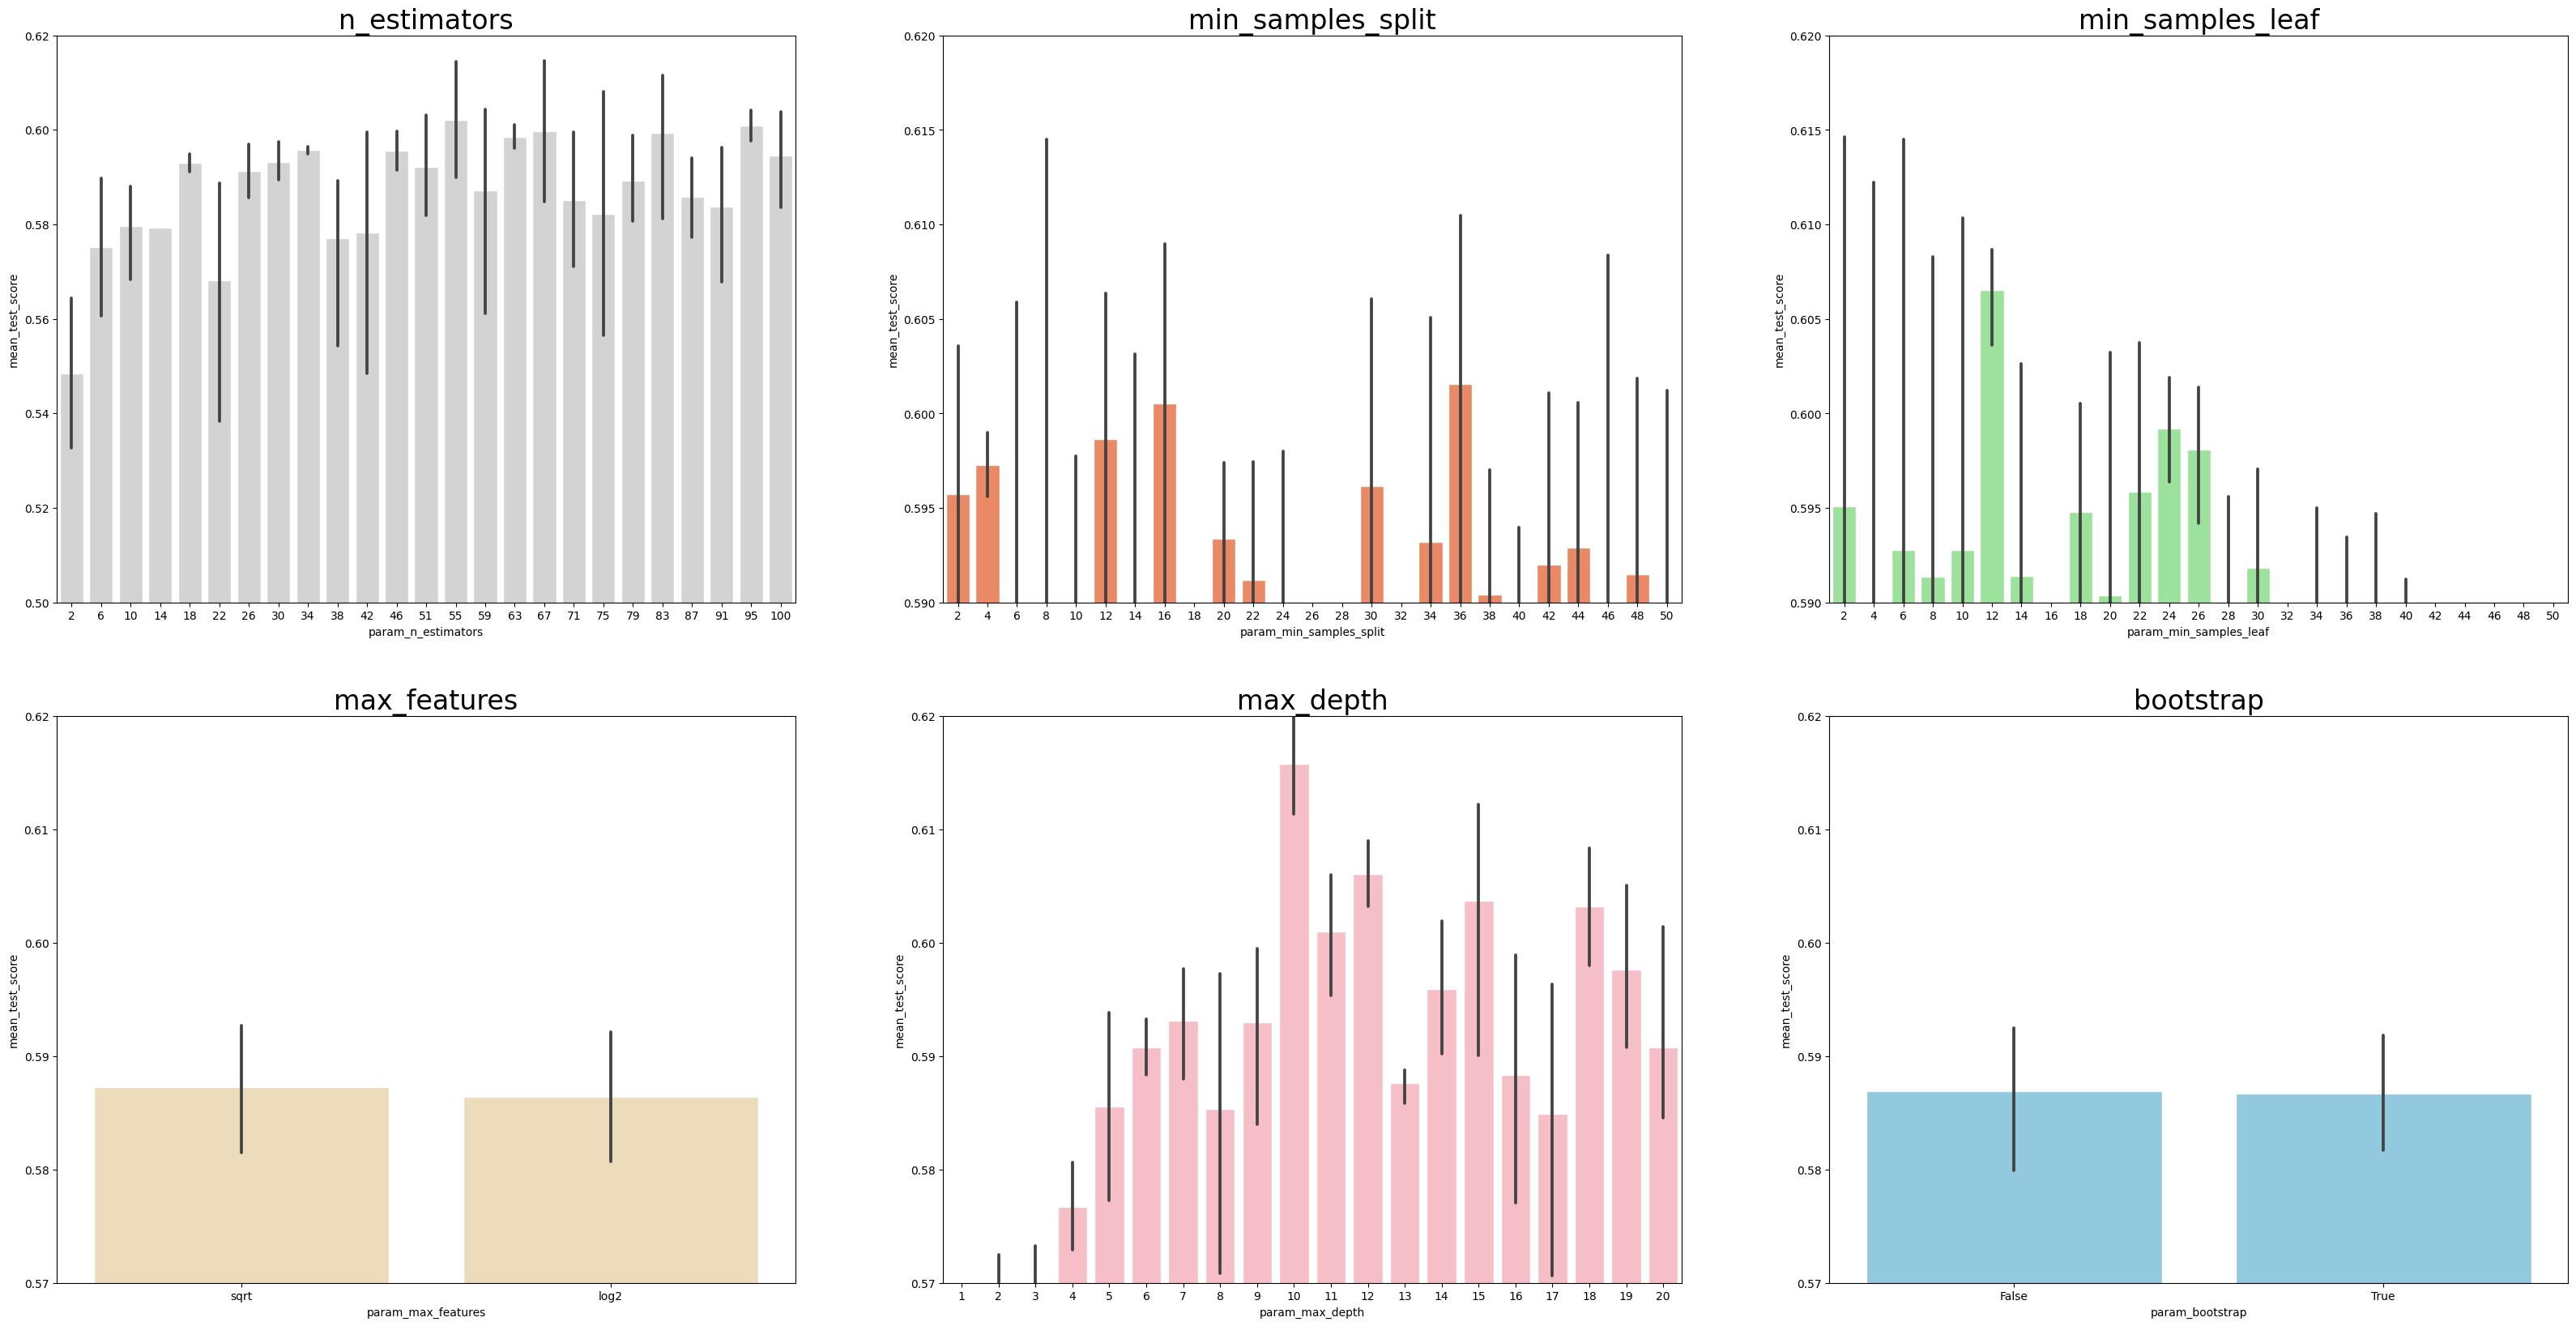

In [91]:
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(40,20)
sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([.5,.62])
axs[0,0].set_title('n_estimators')

sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([.59,.62])
axs[0,1].set_title('min_samples_split')

sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([.59,.62])
axs[0,2].set_title('min_samples_leaf')

sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([.57,.62])
axs[1,0].set_title('max_features')

sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([.57,.62])
axs[1,1].set_title('max_depth')

sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([.57,.62])
axs[1,2].set_title('bootstrap')

plt.show()

Analyzing the graphs, you can see some patterns:
1. n_estimators - choose the best parameters 55, 67, 83
2. min_samples_split - choose the best parameters 12, 16, 36
3. min_samples_leaf - choose the best parameters 4, 8, 12.
4. max_features - variant of log2 and sqrt
5. max_depth - choose the best parameters 10, 15, 18
6. bootstrap - True and False option

### Stage 2. Hyperparameter optimization. GridSearchCV

In [92]:
%%time
1 + 1
n_estimators = [55, 67, 83]
max_features = ['log2', 'sqrt']
max_depth = [10, 15, 18]
min_samples_split = [12, 16, 36]
min_samples_leaf = [4, 8, 12]
bootstrap = [True, False]
class_weight = [{1:3.5}, {1:3.6}, {1:3.4},]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
             'class_weight': class_weight}
model = GridSearchCV(RandomForestClassifier(), 
                     param_dist, 
                     cv = 3, 
                     verbose = 1, 
                     n_jobs=-1)
model.fit(features_other, target_other)

Fitting 3 folds for each of 972 candidates, totalling 2916 fits
CPU times: user 8.3 s, sys: 691 ms, total: 8.99 s
Wall time: 16min


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'class_weight': [{1: 3.5}, {1: 3.6}, {1: 3.4}],
                         'max_depth': [10, 15, 18],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': [4, 8, 12],
                         'min_samples_split': [12, 16, 36],
                         'n_estimators': [55, 67, 83]},
             verbose=1)

The best model is stored in the best_estimator_ attribute

gsearch.best_estimator_
The score of the best model obtained through cross-validation is stored in the best_score_ attribute

gsearch.best_score_
The parameters of the best model are stored in the attribute best_params_

gsearch.best_params_
Thus, having once trained the GridSearchCV object, we immediately get both the best model and the best hyperparameters and the model score obtained using cross-validation. And there is no need for additional training of the model and determination of metrics for the selected validation set.

In [93]:
model.best_estimator_

RandomForestClassifier(class_weight={1: 3.4}, max_depth=18, max_features='log2',
                       min_samples_leaf=4, min_samples_split=12,
                       n_estimators=67)

In [94]:
model.best_score_

0.8516263392807333

Above the threshold of 0.59 on the validation set and the test set. Let's try on a test sample and see how the model behaves on unfamiliar data

## Hyperparameter optimization for the CatBoostClassifier model

Let's try to set up Catboost using cross-validation. We get the base model, we will check it by the F1-measure. 

In [95]:
model_cat = CatBoostClassifier(custom_loss=['F1'], random_seed=12345, logging_level='Silent')

In [96]:
model_cat.fit(features_train, target_train, eval_set=(features_valid, target_valid))

Let's cross-validate using the built-in Pool function

In [97]:
cv_params = model_cat.get_params()
cv_params.update({'loss_function': 'Logloss'})
cv_data = cv(Pool(features_train, target_train),cv_params)

In [98]:
cv_params

{'random_seed': 12345,
 'logging_level': 'Silent',
 'custom_loss': ['F1'],
 'loss_function': 'Logloss'}

In [99]:
print('F1-мера: {}'.format(np.max(cv_data['test-F1-mean'])))

F1-мера: 0.5978681578885929


In [100]:
probabilities_valid = model_cat.predict_proba(features_valid)[:, 1]

auc_roc = roc_auc_score (target_valid, probabilities_valid)

print("AUC:", auc_roc)

AUC: 0.867969334895306


Above the threshold of 0.59 on the validation set and the test set. Good readings of the ROC-AUC metric Let's try it on a test set and see how the model behaves on unfamiliar data

### Conclusion

We selected optimal hyperparameters with the best F1-measure for RandomForestClassifier(class_weight='balanced', max_depth=19, min_samples_leaf=2, min_samples_split=10,n_estimators=30, random_state=12345)

## Model testing

### RandomForestClassifier

In [101]:
model = RandomForestClassifier(class_weight={1: 3.4}, max_depth=18, min_samples_leaf=4,
                       min_samples_split=12, n_estimators=83,
                       random_state=12345)

model_rfc1 = model.fit(features_train, target_train)
predicted_test = model_rfc1.predict(features_test)
print("F1= {:.3f}\n".format(f1_score(target_test, predicted_test)))

probabilities_test = model.predict_proba(features_test)[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_test)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

print("Accuracy = {:.3f}\n".format(accuracy_score(target_test, predicted_test)))

print("Recall = {:.3f}\n".format(recall_score(target_test, predicted_test)))

print("Precision= {:.3f}\n".format(precision_score(target_test, predicted_test)))


F1= 0.636

AUC_ROC = 0.868

Accuracy = 0.851

Recall = 0.611

Precision= 0.662



To find out how much our model differs from the random one, let's calculate the area under the ROC curve - AUCZROC (Area Under Curve ROC).
This is a new quality metric that ranges from 0 to 1. The AUCZROC of a random model is 0.5.

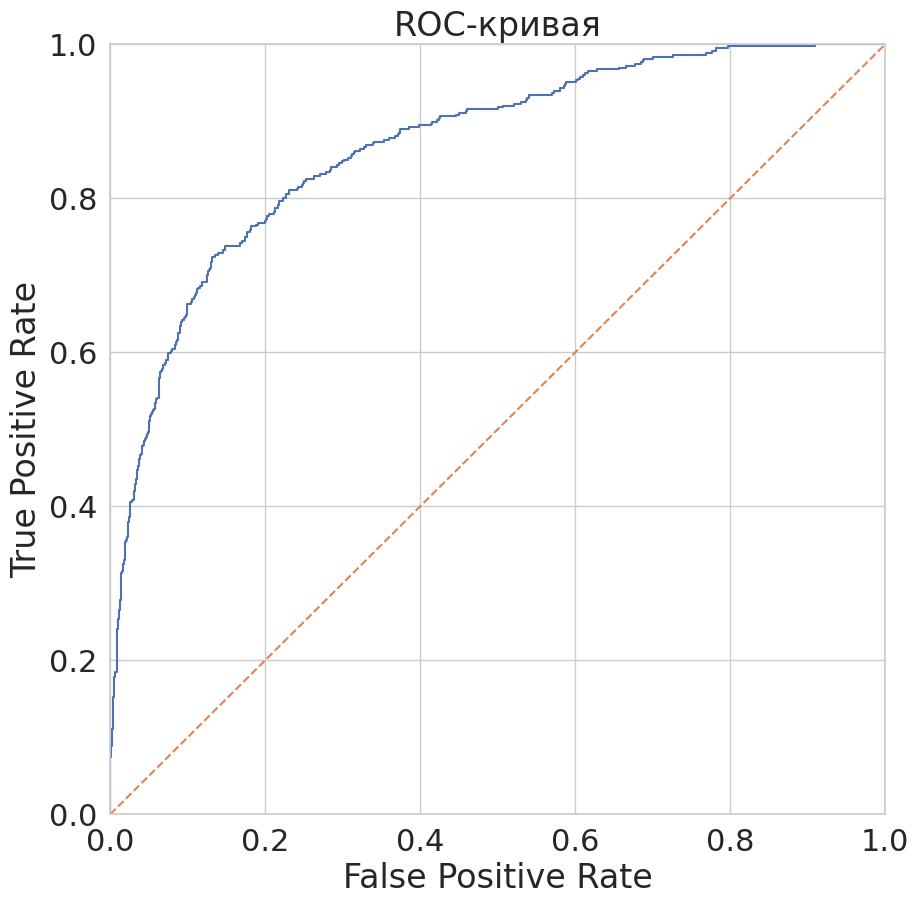

AUC: 0.8682316193493542


In [102]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_test) 

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

auc_roc = roc_auc_score(target_test, probabilities_test)

print("AUC:", auc_roc)

In [103]:
tabl_prec.append(round(f1_score(target_test, predicted_test), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('RandomForestClassifier')
tabl_not.append('test')

### CatBoostClassifier

In [104]:
model_cat = CatBoostClassifier(random_seed=42,logging_level= 'Silent',custom_loss= ['F1'], loss_function= 'Logloss')
model_cat = model_cat.fit(features_train, target_train)
predicted_test = model_cat.predict(features_test)
print("F1= {:.3f}\n".format(f1_score(target_test, predicted_test)))

probabilities_test = model_cat.predict_proba(features_test)[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_test)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

print("Accuracy = {:.3f}\n".format(accuracy_score(target_test, predicted_test)))

print("Recall = {:.3f}\n".format(recall_score(target_test, predicted_test)))

print("Precision= {:.3f}\n".format(precision_score(target_test, predicted_test)))

F1= 0.591

AUC_ROC = 0.873

Accuracy = 0.860

Recall = 0.473

Precision= 0.786



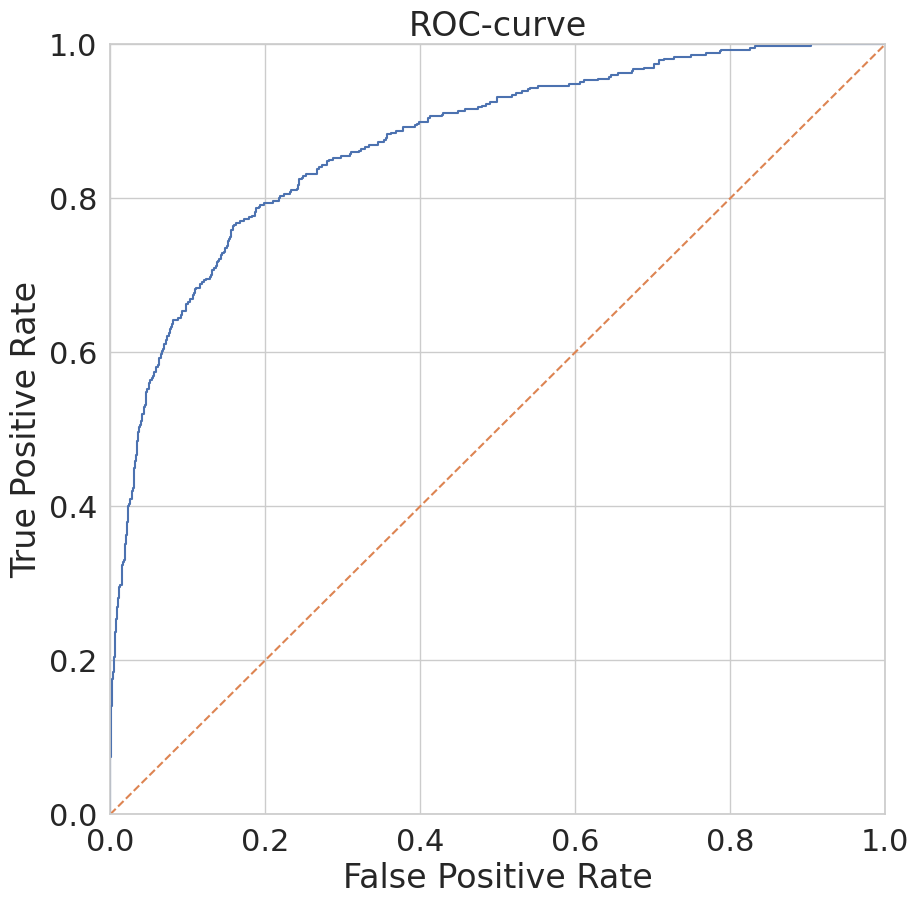

AUC: 0.8729050383297775


In [105]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_test) 

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.show()

auc_roc = roc_auc_score(target_test, probabilities_test)

print("AUC:", auc_roc)

In [106]:
tabl_prec.append(round(f1_score(target_test, predicted_test), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('CatBoostClassifier')
tabl_not.append('test')

In [107]:
table_models = (pd.DataFrame({'Model':tabl_model, 'F1 score':tabl_prec, 'ROC-AUC':tabl_roc_auc, 'Notice': tabl_not}).sort_values(by='F1 score', ascending=False).
                  reset_index(drop=True))
table_models

,Model,F1 score,ROC-AUC,Notice
0,RandomForestClassifier,0.64,0.87,test
1,RandomForestClassifier,0.61,0.84,threshold=0.35
2,CatBoostClassifier,0.61,0.86,threshold=0.25
3,CatBoostClassifier,0.60,0.74,upsampling
4,CatBoostClassifier,0.60,0.86,without_imbalance
5,CatBoostClassifier,0.59,0.87,test
6,RandomForestClassifier,0.58,0.81,class_weight
7,RandomForestClassifier,0.58,0.84,upsampling
8,RandomForestClassifier,0.58,0.84,without_imbalance
9,CatBoostClassifier,0.57,0.85,downsampled


In [108]:
model_cat.feature_importances_

array([11.41660844,  3.05358441, 18.84085193,  7.43120884, 13.65095016,
       18.49680806,  1.12665484,  6.98735623, 10.81494697,  6.24856825,
        1.93246187])

In [109]:
model_rfc1.feature_importances_

array([0.09894422, 0.02281794, 0.30112186, 0.05756063, 0.13047728,
       0.16040435, 0.01282303, 0.05518014, 0.10138008, 0.04774879,
       0.01154167])

In [110]:
features_test.columns

Index(['credit_score', 'gender', 'age', 'tenure', 'balance', 'num_of_products',
       'has_cr_card', 'is_active_member', 'estimated_salary', 'Germany',
       'Spain'],
      dtype='object')

In [111]:
f1_table = pd.DataFrame({'name':features_test.columns,'f1_table':model_rfc1.feature_importances_,'f2_table':model_cat.feature_importances_})
f1_table.sort_values('f1_table',ascending=False)

,name,f1_table,f2_table
2,age,0.301122,18.840852
5,num_of_products,0.160404,18.496808
4,balance,0.130477,13.650950
8,estimated_salary,0.101380,10.814947
0,credit_score,0.098944,11.416608
3,tenure,0.057561,7.431209
7,is_active_member,0.055180,6.987356
9,Germany,0.047749,6.248568
1,gender,0.022818,3.053584
6,has_cr_card,0.012823,1.126655


# Conclusion

The most important signs that bank marketers should pay attention to:

1. customer age
2. the number of bank products used by the client
3. account balance
4. estimated salary
5. credit score

To predict churn, you can use a model based on the Random Forest algorithm with the parameters RandomForestClassifier(class_weight={1: 3.4}, max_depth=18, min_samples_leaf=4,min_samples_split=12, n_estimators=83) and the CatBoostClassifier model(random_seed=42,logging_level= 'Silent',custom_loss= ['F1'], loss_function= 'Logloss')